https://thisdata.com/blog/unsupervised-machine-learning-with-one-class-support-vector-machines/

In [2]:
%matplotlib inline

In [4]:
import matplotlib
import numpy as np  
import pandas as pd  
from sklearn import utils  
import pandas.io.sql as psql
import psycopg2 as pg

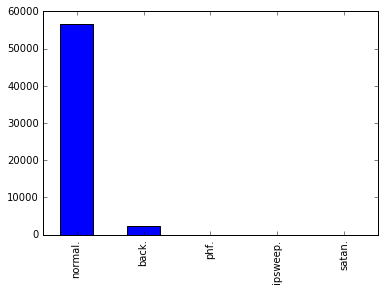

In [21]:
# import the CSV from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# this will return a pandas dataframe.
kddcup = r'E:\heitor.guerra\PycharmProjects\pyLiDARForest\app\sklearn\kddcup.data_10_percent.csv'
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
             "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
             "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
             "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
             "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
             "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
             "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
             "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
             "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

data = pd.read_csv(kddcup, header=None, names=col_names, low_memory=False)

# extract just the logged-in HTTP accesses from the data
data = data[data['service'] == "http"]
data = data[data["logged_in"] == 1]

# let's take a look at the types of attack labels are present in the data.
data.label.value_counts().plot(kind='bar')

In [22]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,58725.000000,58725.000000,5.872500e+04,58725.0,58725.0,58725.0,58725.000000,58725.0,58725.0,58725.000000,...,58725.000000,58725.000000,58725.000000,58725.000000,58725.000000,58725.000000,58725.000000,58725.000000,58725.000000,58725.000000
mean,0.686641,2282.454593,4.658200e+03,0.0,0.0,0.0,0.077258,0.0,1.0,0.036662,...,140.069289,246.700570,0.997880,0.000641,0.051499,0.020208,0.001215,0.000775,0.007308,0.010389
std,14.394064,10259.946866,1.982101e+04,0.0,0.0,0.0,0.382696,0.0,0.0,0.190721,...,104.888467,36.089793,0.018024,0.006456,0.143288,0.027195,0.012157,0.003345,0.051759,0.075507
min,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,218.000000,6.860000e+02,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,30.000000,255.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,253.000000,1.724000e+03,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,130.000000,255.000000,1.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,309.000000,5.053000e+03,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,...,255.000000,255.000000,1.000000,0.000000,0.030000,0.030000,0.000000,0.000000,0.000000,0.000000
max,1440.000000,54540.000000,3.916592e+06,0.0,0.0,0.0,4.000000,0.0,1.0,4.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.200000,1.000000,1.000000


In [23]:
# the full dataset contains features for SMTP, NDP, ICMP, etc.
# here we'll grab just the relevant features for HTTP.
relevant_features = [  
    "duration",
    "src_bytes",
    "dst_bytes",
    "label"
]

# replace the data with a subset containing only the relevant features
data = data[relevant_features]

In [24]:
data.describe()

,duration,src_bytes,dst_bytes
count,58725.000000,58725.000000,5.872500e+04
mean,0.686641,2282.454593,4.658200e+03
std,14.394064,10259.946866,1.982101e+04
min,0.000000,0.000000,0.000000e+00
25%,0.000000,218.000000,6.860000e+02
50%,0.000000,253.000000,1.724000e+03
75%,0.000000,309.000000,5.053000e+03
max,1440.000000,54540.000000,3.916592e+06


In [25]:
# normalise the data - this leads to better accuracy and reduces numerical instability in
# the SVM implementation
data["duration"] = np.log((data["duration"] + 0.1).astype(float)) 
data["src_bytes"] = np.log((data["src_bytes"] + 0.1).astype(float))  
data["dst_bytes"] = np.log((data["dst_bytes"] + 0.1).astype(float))


In [26]:
data.describe()

,duration,src_bytes,dst_bytes
count,58725.000000,58725.000000,58725.000000
mean,-2.263820,5.735731,7.538792
std,0.492619,1.060258,1.329806
min,-2.302585,-2.302585,-2.302585
25%,-2.302585,5.384954,6.531023
50%,-2.302585,5.533785,7.452460
75%,-2.302585,5.733665,8.527757
max,7.272468,10.906691,15.180732


In [28]:
# we're using a one-class SVM, so we need.. a single class. the dataset 'label'
# column contains multiple different categories of attacks, so to make use of 
# this data in a one-class system we need to convert the attacks into
# class 1 (normal) and class -1 (attack)
data.loc[data['label'] == "normal.", "attack"] = 1  
data.loc[data['label'] != "normal.", "attack"] = -1

In [29]:
# grab out the attack value as the target for training and testing. since we're
# only selecting a single column from the `data` dataframe, we'll just get a
# series, not a new dataframe
target = data['attack']

In [50]:
# find the proportion of outliers we expect (aka where `attack == -1`). because 
# target is a series, we just compare against itself rather than a column.
outliers = target[target == -1]  
print("outliers.shape", outliers.shape)  
print("outlier fraction", float(outliers.shape[0])/float(target.shape[0]))

('outliers.shape', (2209L,))
('outlier fraction', 0.03761600681140911)


In [31]:
# drop label columns from the dataframe. we're doing this so we can do 
# unsupervised training with unlabelled data. we've already copied the label
# out into the target series so we can compare against it later.
data.drop(["label", "attack"], axis=1, inplace=True)

In [32]:
# check the shape for sanity checking.
data.shape 

(58725, 3)

In [35]:
from sklearn.cross_validation import train_test_split

In [37]:
# Our train_data shows 80% of the records from the resampled dataset, and we have the right number of features.
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)  
train_data.shape 

(46980, 3)

In [38]:
from sklearn import svm

In [51]:
# set nu (which should be the proportion of outliers in our dataset)
nu = float(outliers.shape[0])/float(target.shape[0])
print("nu", nu)

('nu', 0.03761600681140911)


In [52]:
model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005)

In [53]:
model.fit(train_data)  

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
      max_iter=-1, nu=0.0376160068114, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [54]:
from sklearn import metrics  
preds = model.predict(train_data)  
targs = train_target

print("accuracy: ", metrics.accuracy_score(targs, preds))  
print("precision: ", metrics.precision_score(targs, preds))  
print("recall: ", metrics.recall_score(targs, preds))  
print("f1: ", metrics.f1_score(targs, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds)) 

('accuracy: ', 0.97730949340144746)
('precision: ', 0.99884756180232293)
('recall: ', 0.97755318678402403)
('f1: ', 0.98808565808297566)
('area under curve (auc): ', 0.97430440269961704)


In [55]:
outputfile = 'oneclass_v1.model'  
from sklearn.externals import joblib  
joblib.dump(model, outputfile, compress=9)  

['oneclass_v1.model']

In [58]:
print(type(preds), len(preds))

(<type 'numpy.ndarray'>, 46980)
